In [1]:
import os
import warnings
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings("ignore")

OPENAI_KEY = os.getenv("OPENAI_API_KEY")
HUGGINGFACE_API = os.getenv("HUGGINGFACE_API_KEY")
PINECONE_KEY = os.getenv("PINECONE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", api_key = OPENAI_KEY)

In [3]:
# llm.invoke("Hi").content

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_tavily.tavily_search import TavilySearch

from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [4]:
# Embedding Model
model_name = "abhinand/MedEmbed-large-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=HUGGINGFACE_API)
model = AutoModel.from_pretrained(model_name, token=HUGGINGFACE_API)

def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Pooling the token embeddings
    return embeddings.squeeze().tolist()  # Ensure the output is a flat list

class CustomEmbeddings:
    def embed_query(self, query: str):
        return generate_embeddings(query)

embedding_model = CustomEmbeddings()

# Chaecking embedding size. It should be 1024. Since, our PineconeDB has 1024 embedding size we need to query user question to 1024 dim
# len(embedding_model.embed_query("hi"))

In [5]:
# Initializing the Retriever

pc = Pinecone(api_key=PINECONE_KEY)
index = pc.Index("personal-test-1")
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embedding_model,
    text_key="text",
    namespace=None
)

In [6]:
retriever=vectorstore.as_retriever()

In [8]:
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_medical_knowledge",
    description=(
        "Search and return authoritative medical information from the Pinecone vector store. "
        "The index contains peer-reviewed clinical studies, treatment guidelines, drug monographs, "
        "and other curated healthcare content. Invoke this tool **only** when the user explicitly asks a medical-related "
        "question requiring sourced data from the index (e.g., disease mechanisms, therapy options, statistics, references). "
        "For any non-medical query, casual greeting (‘hi’, ‘hello’, ‘how are you’), or general conversation, respond directly "
        "without using this tool."
    ),
)

In [ ]:
# from langchain_community.tools.tavily_search import TavilySearchResults

# tavily = TavilySearchResults(api_key=TAVILY_API_KEY)

tavily_tool = TavilySearch(max_results=5, topic="general", language="en",
                           include_answer=True, include_raw_content=True,
                           description=("Use this tool for real-time news or updates. "
                                    "Only call when question requires up-to-date info."))


In [11]:
tools=[retriever_tool, tavily_tool]
retrieve=ToolNode([retriever_tool, tavily_tool])

In [12]:
# ===== 3.  Core prompts =====
SYSTEM_PROMPT = (
    "You are a senior USMLE professor. Answer only with correct medical information. "
    "Cite your reasoning step by step before giving the final answer."
)

ASSISTANT_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT),
        ("human", "{question}")
    ]
)

RAG_PROMPT = PromptTemplate(
    template=(
        SYSTEM_PROMPT
        + "\n\n<context>\n{context}\n</context>\n\n"
        + "Question: {question}\nAnswer step-by-step:"
    ),
    input_variables=["context", "question"],
)

GRADER_PROMPT = PromptTemplate(
    template=(
        "You are a grader deciding if a retrieval context answers the question.\n"
        "Context: {context}\n\nQuestion: {question}\n\n"
        "Respond with exactly 'yes' or 'no'."
    ),
    input_variables=["context", "question"],
)

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
from judgeval.common.tracer import Tracer, wrap
from judgeval.scorers import AnswerRelevancyScorer,FaithfulnessScorer
from judgeval.integrations.langgraph import JudgevalCallbackHandler
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()
JUDGMENT_API_KEY=os.getenv("JUDGMENT_API_KEY")
JUDGMENT_ORG_ID = os.getenv("JUDGMENT_ORG_ID")

client = wrap(OpenAI())
judgment = Tracer(project_name="USMLE_Step1", api_key= JUDGMENT_API_KEY,organization_id=JUDGMENT_ORG_ID)
handler = JudgevalCallbackHandler(judgment)

In [15]:
def tavily_search(state: AgentState) -> AgentState:
    """Run a Web search when the vector store has no hits."""
    print("---TAVILY WEB SEARCH---")
    question = state["messages"][0].content
    snippets = tavily_tool.invoke(question)           # → list[str]
    joined   = "\n\n---\n\n".join(snippets)
    return {"messages": [AIMessage(content=joined)]}

In [22]:
from langchain_core.tools import StructuredTool

def ai_assistant(state: AgentState):
    """Entry-point node: decide whether to call tools."""
    messages = state["messages"]

    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content

        chain = ASSISTANT_PROMPT | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [23]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [24]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter", "Tavily_Search"]:
    """Route based on doc availability **and** relevance."""

    question = state["messages"][0].content
    docs     = state["messages"][-1].content        # string after join()

    # ①  If retriever found nothing → Web search
    if docs.strip() == "":
        print("---NO DOCS FOUND → WEB SEARCH---")
        return "Tavily_Search"

    # Otherwise grade relevance
    llm_with_structure_op=llm.with_structured_output(grade)
    
    chain = GRADER_PROMPT | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score.lower()

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [25]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    rag_chain = RAG_PROMPT | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [26]:
from langchain_core.messages import  HumanMessage

def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Rewrite this question so that a retrieval system can fetch the most relevant "
        "clinical information.\nOriginal: {question}\nRewritten:""")
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [27]:
def judgment_eval(state:AgentState):
    user_input = str(state["messages"][0].content)
    llm_output = str(state["messages"][-1].content)
    model_name="gpt-4.1-mini-2025-04-14"

    rc = []
    for i in retriever.invoke(user_input):
        rc.append(i.page_content)
    retrieval_context = list(rc[0])

    judgment.async_evaluate(
        scorers=[AnswerRelevancyScorer(threshold=0.8),FaithfulnessScorer(threshold=0.8)],
        # scorers=[FaithfulnessScorer(threshold=0.8)],
        input=user_input,
        actual_output=llm_output,
        model=model_name,
        retrieval_context=retrieval_context
    )

    return state

In [28]:
workflow=StateGraph(AgentState)

workflow.add_node("AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)
workflow.add_node("Tavily_Search", tavily_search)
workflow.add_node("judgment_eval", judgment_eval)

workflow.add_edge(START,"AI_Assistant")

workflow.add_conditional_edges("AI_Assistant",
                            tools_condition,
                            {"tools": "Vector_Retriever",
                                END: END,})

workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter",
                            "tavily_search": "Tavily_Search"
                            }
                            )

workflow.add_edge("Tavily_Search", "AI_Assistant")
workflow.add_edge("Tavily_Search", "Output_Generator")
workflow.add_edge("Output_Generator", "judgment_eval")
workflow.add_edge("judgment_eval", END)
workflow.add_edge("Query_Rewriter", "AI_Assistant")


graph=workflow.compile()

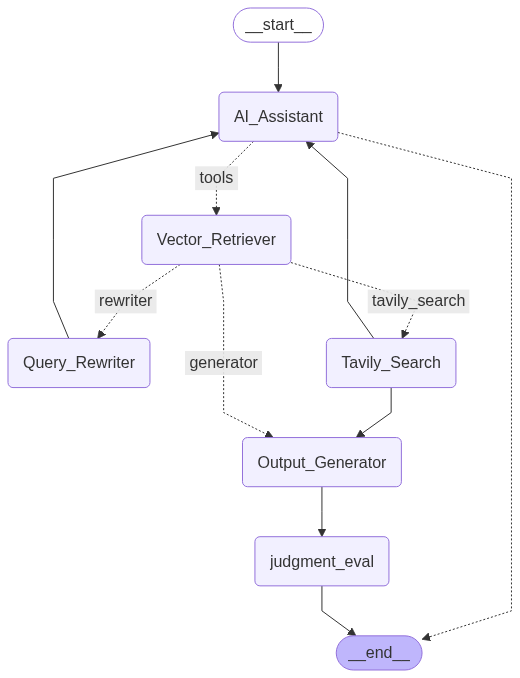

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# response = graph.invoke({"messages":["Give the table of lysosomal storage disorders"]})

In [ ]:
# print(response["messages"][-1].content)

In [57]:
question1=''' 
A 76-year-old African American man presents to his primary care 
provider complaining of urinary frequency. He wakes up 3-4 times per night 
to urinate while he previously only had to wake up once per night. He also 
complains of post-void dribbling and difficulty initiating a stream of 
urine. He denies any difficulty maintaining an erection. His past medical 
history is notable for non-alcoholic fatty liver disease, hypertension, 
hyperlipidemia, and gout. He takes aspirin, atorvastatin, enalapril, and 
allopurinol. His family history is notable for prostate cancer in his 
father and lung cancer in his mother. He has a 15-pack-year smoking 
history and drinks alcohol socially. On digital rectal exam, his prostate 
is enlarged, smooth, and non-tender. Which of the following medications is 
indicated in this patient? 
Options: 
A: Clonidine, 
B: Hydrochlorothiazide, 
C: Midodrine, 
D: Oxybutynin, 
E: Tamsulosin 
'''

In [25]:
question2="A clinical trial compares a new antihypertensive medication with a placebo, using randomization and double-blinding. What type of analysis includes all subjects based on their original treatment assignment, regardless of compliance?"

In [32]:
question1="What is the latest news in USMLE Step1?"

🔍 You can view your trace data here: ]8;id=261407;https://app.judgmentlabs.ai/app/project/2cd0d259-b2c9-41d3-b025-04beceaa0a35/monitor?trace_id=94554d83-32a8-43db-ac92-d3e813d22ceb&show_trace=true\View Trace]8;;\

---DECISION: DOCS RELEVANT---
---GENERATE---
Executed Nodes: ['AI_Assistant', 'Vector_Retriever', 'Output_Generator', 'judgment_eval']
Executed Tools: ['tavily_search']
Node/Tool Flow: ['Vector_Retriever:tavily_search']
Final State: {'messages': [HumanMessage(content='What is the latest news in USMLE Step1?', additional_kwargs={}, response_metadata={}, id='55241296-803e-4123-86aa-1636bb0e2e88'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aCWgqJ9asQSRtkS23aSj9Ucj', 'function': {'arguments': '{"query":"latest news in USMLE Step1","topic":"news","search_depth":"advanced","time_range":"month"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 879, 'total_tokens': 915, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 
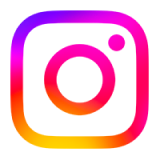
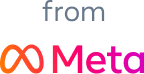

In [33]:
from judgeval.integrations.langgraph import JudgevalCallbackHandler

handler = JudgevalCallbackHandler(judgment)
def run_graph():
    initial_state = {"messages": [HumanMessage(content=question1)]}
    config_with_callbacks = {"callbacks": [handler]}
    
    final_state = graph.invoke(initial_state, config=config_with_callbacks)
    
    print("Executed Nodes:", handler.executed_nodes)
    print("Executed Tools:", handler.executed_tools)
    print("Node/Tool Flow:", handler.executed_node_tools)
    print("Final State:", final_state)
if __name__ == "__main__":
    run_graph()